In [1]:
suppressMessages({
    library(tidyverse)
    library(GenomicRanges)
    library(GenomicFiles)
    library(rtracklayer)
    library(data.table)
    library(scales)
    library(limma)
});

options(repr.plot.width=2, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml", digits=3);
theme_set(theme_classic(base_family = "Lucida Sans"));
mycols = c('forestgreen', '#555555', 'firebrick');

In [2]:
ESize = fasta.seqlengths("./data/eSTARR_EnhFusions.fa");
BCTable = read.csv("./data/eSTARR_EnhFusions_UMIcounts.csv", sep="\t", header=T );
BCTable$Element = as.character(BCTable$Element);
rownames(BCTable) = BCTable$Element;
BCTable[,-1] = t( 1E6 / colSums(BCTable[,-1]) * t(BCTable[,-1]) );

nDNA = BCTable[, grepl('DNA', colnames(BCTable), fixed=T) ];
skip = apply(nDNA < 100, 1, any);
BCTable = BCTable[!skip,];
head(BCTable);

,Element,DNA1,DNA2,DNA3,Input,RNA1,RNA2,RNA3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KSUUT0003_KSUUT0003,KSUUT0003_KSUUT0003,4557,7096,7783,3185,4965,3587,4337
KSUUT0003_KSUUT0008,KSUUT0003_KSUUT0008,6098,8878,11277,3772,21556,10439,17817
KSUUT0003_KSUUT0025,KSUUT0003_KSUUT0025,4029,6006,6785,2601,3427,2492,3625
KSUUT0003_KSUUT0114,KSUUT0003_KSUUT0114,3293,7278,5717,1980,4122,3094,3935
KSUUT0003_KUUAE0004,KSUUT0003_KUUAE0004,4297,5707,7315,2661,5720,3206,5177
KSUUT0003_KUUAE0024,KSUUT0003_KUUAE0024,3078,5496,5325,2061,4118,2820,4228


In [3]:
nDNA = BCTable[, grepl('DNA', colnames(BCTable), fixed=T) ];
nRNA = BCTable[, grepl('RNA' , colnames(BCTable), fixed=T) ];
colnames(nDNA) = gsub('DNA', '', colnames(nDNA), fixed=T);
colnames(nRNA) = colnames(nDNA);

Preformatted = cbind(nRNA, nDNA);
coldata = data.frame(
    RvD=rep(c(1, 0), each=3),
    Rep=1:3
);
mdes = model.matrix(~RvD, data=coldata);
vdata = voomWithQualityWeights(Preformatted, design=mdes, plot=F);
vcorrf = duplicateCorrelation(vdata, mdes, block = coldata$Rep)$consensus.correlation;

fit = eBayes(lmFit(vdata, mdes, block = coldata$Rep, correlation = vcorrf));
hits = topTable(fit, coef='RvD', number=Inf, sort.by = "none");

# +2 to logFC aligns this dataset to previous eSTARR
# dataset which was normalized to neutral controls.
# See cell 7 below for comparison plot.
vnorm = hits;
vnorm$normFC = vnorm$logFC+2;
vnorm$Element=as.character(rownames(vnorm));
vnorm = vnorm[,c("Element", "normFC", "P.Value")];
head(vnorm);

Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”

,Element,normFC,P.Value
,<chr>,<dbl>,<dbl>
KSUUT0003_KSUUT0003,KSUUT0003_KSUUT0003,1.38,0.01303
KSUUT0003_KSUUT0008,KSUUT0003_KSUUT0008,3.04,0.00241
KSUUT0003_KSUUT0025,KSUUT0003_KSUUT0025,1.24,0.00495
KSUUT0003_KSUUT0114,KSUUT0003_KSUUT0114,1.34,0.01960
KSUUT0003_KUUAE0004,KSUUT0003_KUUAE0004,1.83,0.45700
KSUUT0003_KUUAE0024,KSUUT0003_KUUAE0024,1.69,0.18440


In [4]:
norm=vnorm;
nrow(norm)

ele1 = substr(norm$Element, 1, 9);
ele2 = substr(norm$Element, 11, 19);
eles = unique(append(ele1, ele2));
diff = ele1 != ele2;
sum(diff)

singles = as.data.frame(norm[!diff,]);
singles$ID = ele1[!diff];
rownames(singles) = singles$ID;

[1] 235

[1] 187

In [5]:
fused = as.data.frame( norm[diff,] );
nrow(fused);

ele1 = substr(fused$Element, 1, 9);
ele2 = substr(fused$Element, 11, 19);
fused = cbind( fused, ele1, ele2, singles[ele1,2], singles[ele2,2] );
rownames(fused) = NULL;
rm(ele1, ele2);

colnames(fused) = c( "Element", "A", "A.p", "ele1", "ele2", "B", "C" );
fused$e1 = ifelse(fused$B > fused$C, fused$B, fused$C);
fused$e2 = ifelse(fused$B > fused$C, fused$C, fused$B);

[1] 187

In [6]:
Summary = read.csv("./data/K562_eSTARR_voom.csv", header=T);
Summary$ID = as.character(Summary$ID);
enh = Summary %>% filter(call=="Enhancer") %>% select(ID);
Summary = Summary %>% filter(ID %in% eles);
head(Summary);
enh = unique(enh$ID);

out = left_join(Summary, singles, by="ID");

logFC.CW,ID,p.CW,logFC.CCW,p.CCW,logFC,call,Size
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>
3.04,KUUAE0106,8.68e-17,4.49,1.34e-21,3.94,Enhancer,521
3.89,KUUUT0043,1.89e-22,3.96,1.52e-22,3.93,Enhancer,299
3.31,KUUAE0071,2.23e-20,4.24,1.89e-22,3.85,Enhancer,270
3.21,KSUUT0008,2.23e-20,3.86,1.89e-22,3.57,Enhancer,292
3.13,KUUUT0021,1.55e-20,3.50,3.96e-22,3.33,Enhancer,280
2.88,KUUAE0147,4.24e-19,2.94,4.61e-20,2.91,Enhancer,252


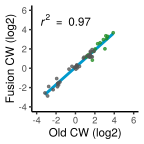

In [7]:
lm_eqn2 = function(x, y) {
    ct = cor.test(x, y);
    eq = substitute(italic(r^2)~"="~ rval, # ~"  "~italic(p) == pv,
        list( #pv = format(ct$p.value, digits = 2),
             rval = format(unname(ct$estimate^2), digits = 2)));
    return(as.character(as.expression(eq)));
}

print(
    ggplot(out, aes(x=logFC.CW, y=normFC, col=call)) +
    xlab("Old CW (log2)") + ylab("Fusion CW (log2)") +
    xlim(-4, 6) + ylim(-4, 6) + 
    geom_smooth( method='lm', col='deepskyblue3' ) +
    geom_text(aes( -1, 5, label = lm_eqn2(out$logFC.CW, out$normFC)), data=data.frame(), parse = T, col='black' ) +
    geom_point(alpha=0.75, pch=19, show.legend=F, size=0.5) +
    scale_color_manual(values=mycols)
);
#ggsave("./TREF_Replication.pdf", width=2, height=2);

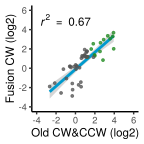

In [8]:
print(
    ggplot(out, aes(x=logFC, y=normFC, col=call)) +
    xlab("Old CW&CCW (log2)") + ylab("Fusion CW (log2)") +
    xlim(-4, 6) + ylim(-4, 6) + 
    geom_smooth( method='lm', col='deepskyblue3' ) +
    geom_text(aes( -1, 5, label = lm_eqn2(out$logFC, out$normFC)), data=data.frame(), parse = T, col='black' ) +
    geom_point(alpha=0.75, pch=19, show.legend=F, size=0.5) +
    scale_color_manual(values=mycols)
);

Warning message:
“Removed 63 rows containing missing values (geom_point).”

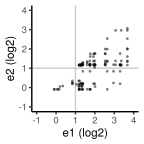

In [9]:
fused %>%
    ggplot(aes(e1, e2)) +
    xlim(-1, 4) + ylim(-1, 4) +
    xlab("e1 (log2)") + ylab("e2 (log2)") +
    geom_hline(aes(yintercept=1), col="#cccccc") +
    geom_vline(aes(xintercept=1), col="#cccccc") +
    geom_point(alpha=0.5, size=0.5, pch=16);
#ggsave("./TREF_E1vE2.pdf", width=2, height=2);

In [10]:
print("enhancer-enhancer pairs");
ffused = fused[fused$ele1 %in% enh & fused$ele2 %in% enh & fused$A>1,];
nrow(ffused);

[1] "enhancer-enhancer pairs"


[1] 25

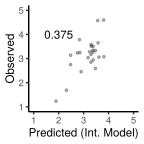

In [11]:
intm = lm( A ~ e1 * e2, data=ffused );
tibble(y=ffused$A, x=intm$fitted) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Int. Model)") + ylab("Observed") +
    xlim(1, 5) + ylim(1, 5) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5) +
    geom_text( data=data.frame(), aes(x=2, y=4, label=round(summary(intm)$adj.r.squared,3)) );
#ggsave("./TREF_EnhSum.pdf", width=2, height=2);

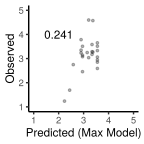

In [12]:
maxm = lm( A ~ e1, data=ffused );
tibble(y=ffused$A, x=maxm$fitted) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Max Model)") + ylab("Observed") +
    xlim(1, 5) + ylim(1, 5) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5) +
    geom_text( data=data.frame(), aes(x=2, y=4, label=round(summary(maxm)$adj.r.squared,3)) );
#ggsave("./TREF_EnhMax.pdf", width=2, height=2);

In [13]:
summary(intm);


Call:
lm(formula = A ~ e1 * e2, data = ffused)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8805 -0.4410 -0.0238  0.2854  1.0079 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   -3.263      2.017   -1.62   0.1206   
e1             1.925      0.631    3.05   0.0061 **
e2             3.220      1.292    2.49   0.0211 * 
e1:e2         -0.922      0.391   -2.36   0.0280 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.564 on 21 degrees of freedom
Multiple R-squared:  0.453,	Adjusted R-squared:  0.375 
F-statistic:  5.8 on 3 and 21 DF,  p-value: 0.00472


In [14]:
summary(maxm);


Call:
lm(formula = A ~ e1, data = ffused)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9961 -0.4895 -0.0376  0.2451  1.3946 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)    1.444      0.597    2.42   0.0238 * 
e1             0.573      0.195    2.94   0.0074 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.622 on 23 degrees of freedom
Multiple R-squared:  0.273,	Adjusted R-squared:  0.241 
F-statistic: 8.63 on 1 and 23 DF,  p-value: 0.00741


In [15]:
anova(intm, maxm);

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
21,6.69,NA,NA,NA,NA
23,8.89,-2,-2.21,3.47,0.05


[1] "test on enhancer-inactive pairs"


Warning message:
“Removed 12 rows containing missing values (geom_point).”

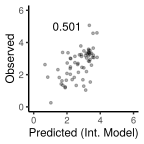

In [16]:
print("test on enhancer-inactive pairs");
nfused = fused[(fused$ele1 %in% enh | fused$ele2 %in% enh) & fused$e2 > -1,];
mout = predict( intm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Int. Model)") + ylab("Observed") +
    xlim(0, 6) + ylim(0, 6) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5) +
    geom_text( data=data.frame(), aes(x=2, y=5, label=rsq) );
#ggsave("./TREF_EnhPairs.pdf", width=2, height=2);

[1] "test on inactive-inactive pairs"


Warning message:
“Removed 27 rows containing missing values (geom_point).”

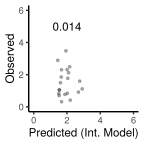

In [17]:
print("test on inactive-inactive pairs");
nfused = fused[!(fused$ele1 %in% enh | fused$ele2 %in% enh) & fused$e2 > -1,];
mout = predict( intm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Int. Model)") + ylab("Observed") +
    xlim(0, 6) + ylim(0, 6) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5) +
    geom_text( data=data.frame(), aes(x=2, y=5, label=rsq) );
#ggsave("./out/TREF_NonenhPairs.pdf", width=2, height=2);

[1] "test on all pairs"


Warning message:
“Removed 15 rows containing missing values (geom_point).”

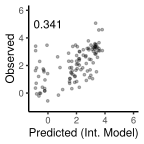

In [18]:
# test interaction vs max models on full dataset
nfused = fused[fused$e2 > -1,];
mout = predict( intm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Int. Model)") + ylab("Observed") +
    xlim(-1, 6) + ylim(-1, 6) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5) +
    geom_text( data=data.frame(), aes(x=0, y=5, label=rsq) );

Warning message:
“Removed 2 rows containing missing values (geom_point).”

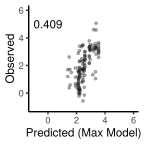

In [19]:
mout = predict( maxm, nfused );
rsq = round(cor.test( nfused$A, mout)$estimate^2, 3);
tibble(y=nfused$A, x=mout) %>% ggplot(aes(x, y)) +
    xlab("Predicted (Max Model)") + ylab("Observed") +
    xlim(-1, 6) + ylim(-1, 6) +
    geom_point(alpha=0.3, pch=19, show.legend=F, size=0.5) +
    geom_text( data=data.frame(), aes(x=0, y=5, label=rsq) );